Before you run this on Colab you have to move the 'CNN-DiseaseDet..' folder to your google drive or clone the Githup repo to the drive

In [72]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
You have to allow colab access to your google drive

In [1]:
# import libraries
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "./PlantImgData"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
def dataset_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
train_data, val_data, test_data = dataset_splitting(dataset)

In [15]:
print(train_data)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 
3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


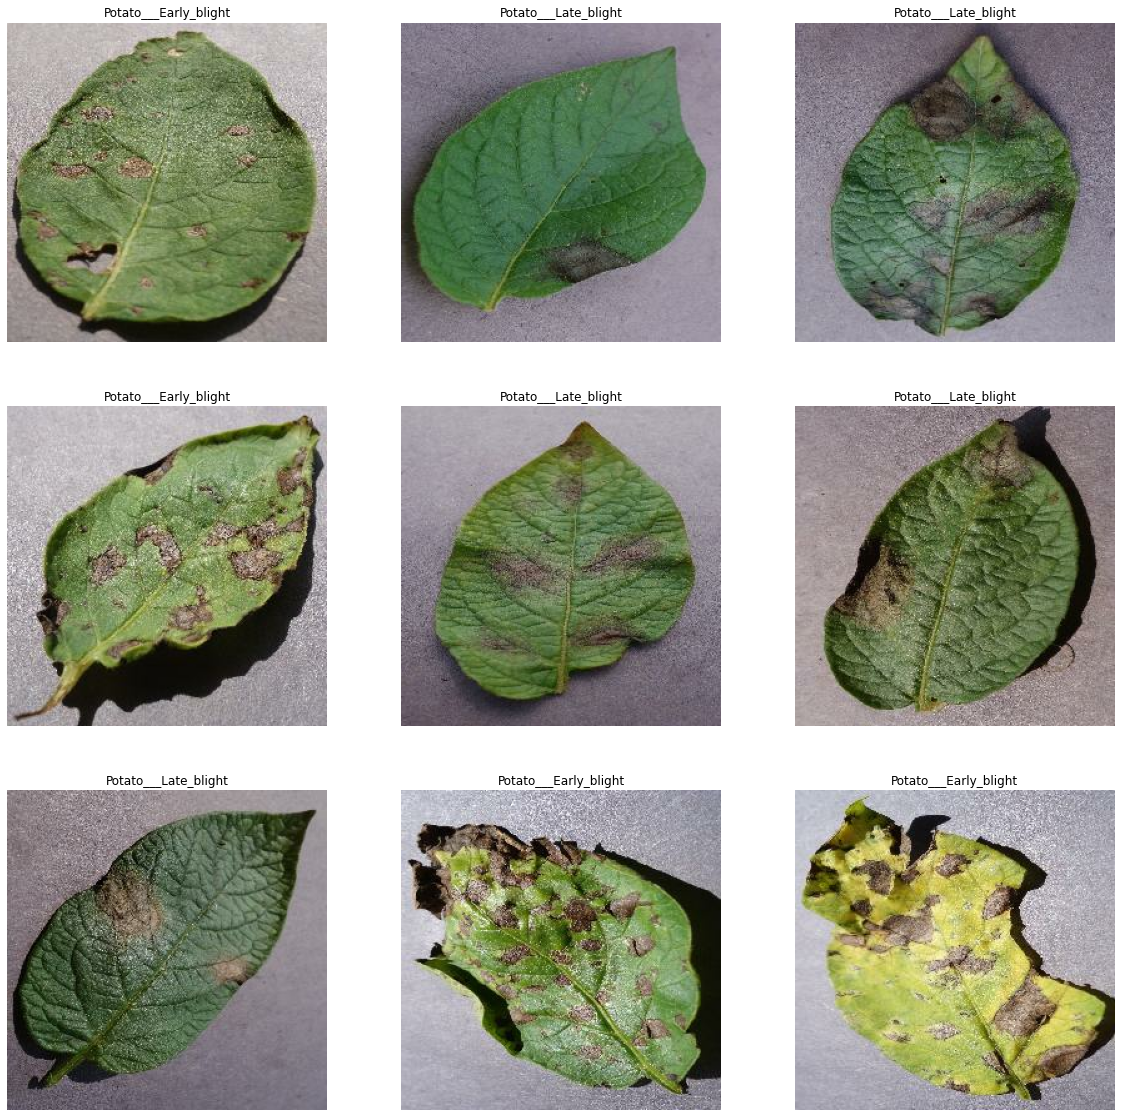

In [11]:
plt.figure(figsize=(20, 20))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
# caching,shuffle and prefetching the data
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [18]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

The Model

In [20]:
# Creating Convolution layer 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [22]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_data)

Epoch 1/10
54/54 [==============================] - 154s 3s/step - loss: 1.2548 - accuracy: 0.4789 - val_loss: 0.9266 - val_accuracy: 0.4479
Epoch 2/10
54/54 [==============================] - 144s 3s/step - loss: 0.8450 - accuracy: 0.5827 - val_loss: 1.0771 - val_accuracy: 0.5990
Epoch 3/10
54/54 [==============================] - 146s 3s/step - loss: 0.6819 - accuracy: 0.7171 - val_loss: 1.0696 - val_accuracy: 0.6302
Epoch 4/10
54/54 [==============================] - 145s 3s/step - loss: 0.5061 - accuracy: 0.7899 - val_loss: 0.7370 - val_accuracy: 0.6615
Epoch 5/10
54/54 [==============================] - 147s 3s/step - loss: 0.3939 - accuracy: 0.8392 - val_loss: 0.3904 - val_accuracy: 0.8490
Epoch 6/10
54/54 [==============================] - 132s 2s/step - loss: 0.3247 - accuracy: 0.8680 - val_loss: 0.3768 - val_accuracy: 0.8490
Epoch 7/10
54/54 [==============================] - 126s 2s/step - loss: 0.2543 - accuracy: 0.8991 - val_loss: 0.2803 - val_accuracy: 0.9115
Epoch 8/10
54

In [87]:
scores = model.evaluate(train_data)

54/54 [==============================] - 37s 663ms/step - loss: 0.0859 - accuracy: 0.9701


In [88]:
history

In [89]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [90]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

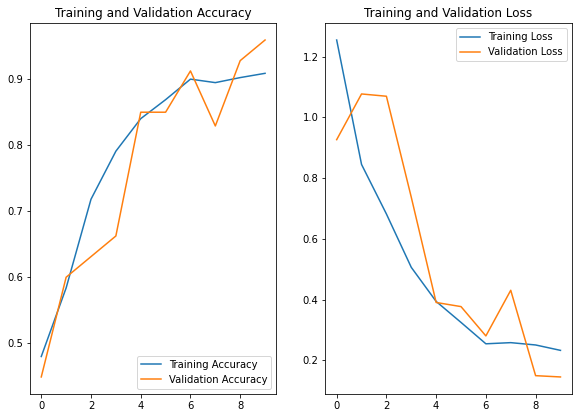

In [25]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Late_blight
1/1 [==============================] - 1s 899ms/step
Predicted label :  Potato___Late_blight


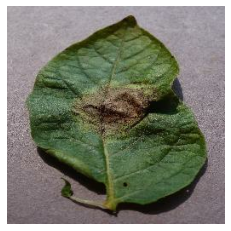

In [26]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 1s 592ms/step


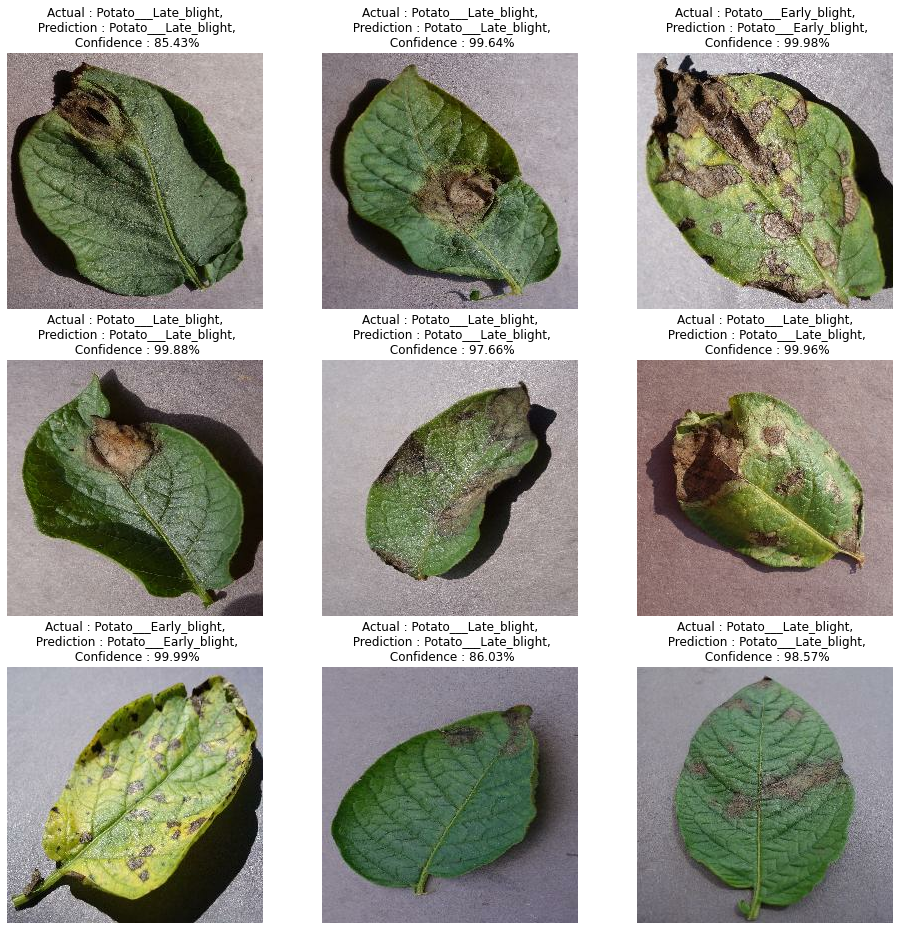

In [29]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [ ]:
# model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
# model.save(f"../models/{model_version}")